## Objective
This notebook focuses on building modern Transformer architecture applied to customer sentiment analysis using the IMDB dataset. This includes:


1.   Implementing, training, and evaluating two neural network architectures (basic and advanced Transformer models)
2.   Comparing their performance on sentiment classification using appropriate metrics.



### Task 1: Utilise Libraries/Dataset

In [ ]:
# A. Import the necessary libraries (TensorFlow, datasets, Keras, pandas, Matplotlib, sklearn, etc.)
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt
from tensorflow import keras
from datasets import load_dataset

In [ ]:
# B. Load the IMDB dataset using load_dataset("imdb")
def load_and_process_imdb_dataset():
  dataset = load_dataset("imdb")
  print("Dataset shape:", dataset.shape)
  train_data = dataset['train']
  test_data = dataset['test']
  #print(type(train_data))         # type is Dataset

  # C. Convert data to pandas DataFrames and print sample sizes
  df_train = pd.DataFrame(train_data)
  df_test = pd.DataFrame(test_data)
  df_data = pd.concat([df_train, df_test])
  print("Shape of df_data", df_data.shape)
  x_train = df_train['text']
  y_train = df_train['label']
  x_test = df_test['text']
  y_test = df_test['label']
  print("Data converted to dataframe:", type(df_train), type(df_test))
  print("Training data size: ", df_train.shape)
  print("Test data size: ", df_test.shape)
  print("Shape of x train and y train: ", x_train.shape, y_train.shape)
  print("Shape of x test and y test: ", x_test.shape, y_test.shape)

  #print(type(x_train))
  #print(type(df_train['text']))
  print("X train sample data:\n", x_train.head())
  print("y train sample data:\n", y_train.head())
  #df_train.to_csv("imdb_df_train.csv")
  #df_test.to_csv("imdb_df_test.csv")

  return df_data, df_train, df_test, x_train, y_train, x_test, y_test

### Task 2: Data Processing and Exploration

In [ ]:
# A. Generate two EDA visualisations (e.g., review length distribution, class distribution)
# review length distribution
def eda(df_data, df_train, df_test, x_train, y_train, x_test, y_test):
  plt.hist(df_data['text'].apply(len), bins=50)
  plt.xlabel("Review Length")
  plt.ylabel("Number of Samples")
  plt.title("Review Length Distribution")
  plt.show()

  # class distribution
  print(df_data['label'].value_counts())
  #plt.bar(df_train['label'].value_counts())
  #plt.show()
  df_data['label'].value_counts().plot(kind='bar')
  plt.xlabel("Label")
  plt.ylabel("Value Counts")
  plt.title("Class Distribution")
  plt.show()

  # B. Check for missing values and data quality
  print("Null values in x train data: ", x_train.isnull().sum())
  print("Null values in y train data: ", y_train.isnull().sum())
  print("Null values in x test data: ", x_test.isnull().sum())
  print("Null values in y test data: ", y_test.isnull().sum())

  # data quality check for duplicates
  print("Number of duplicated records in training data: ", df_train.duplicated(subset=['text']).sum())
  print("Number of duplicated records in test data: ",df_test.duplicated(subset=['text']).sum())

  # review length outliers using interquantile range method
  review_lengths = df_data["text"].apply(len)
  print("review_lengths: ", review_lengths)
  Q1_quantile = review_lengths.quantile(0.25)
  Q3_quantile = review_lengths.quantile(0.75)
  IQR = Q3_quantile - Q1_quantile

  # bounds for outliers
  lower_bound = Q1_quantile - 1.5 * IQR
  upper_bound = Q3_quantile + 1.5 * IQR

  print("Lower and upper bound of text length:", lower_bound, upper_bound)

  # get rows with text length either less than lower bound or greater than upper bound
  num_outliers_lower = df_data[df_data["text"].apply(len) < lower_bound].count()
  num_outliers_upper = df_data[df_data["text"].apply(len) > upper_bound].count()

  print("Num of outliers:", num_outliers_lower, num_outliers_upper)

  # we can choose to either remove these rows or keep them.
  # since removing them will lead to loss of significant number of rows (3737 rows), we can choose to keep them


  # C. Normalise and tokenise text, pad sequences to a consistent length
  from tensorflow.keras.preprocessing.text import Tokenizer
  from tensorflow.keras.preprocessing.sequence import pad_sequences

  # tokenize text
  # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
  # Tokenizer converts raw text into numerical representations suitable for machine learning models
  tokenizer = Tokenizer(num_words = 10000, oov_token="<OOV>")

  #  scan all the provided texts and create a dictionary mapping words to their frequency and then to an integer index
  # # Learns the frequency of each word, assigning them a unique index. This index will be used to encode reviews
  print(type(x_train), type(df_train['text']))
  tokenizer.fit_on_texts(x_train)
  tokenizer.fit_on_texts(x_test)

  # convert text to sequences (needed for embedding layer)
  x_train_sequence = tokenizer.texts_to_sequences(x_train)
  x_test_sequence = tokenizer.texts_to_sequences(x_test)

  # pad sequences to a consistent length
  # D. Convert text into appropriate format using Keras Tokenizer (e.g., maxlen=256)
  x_train = pad_sequences(x_train_sequence, maxlen=256, truncating="post", padding='post')
  x_test = pad_sequences(x_test_sequence, maxlen=256, truncating="post", padding='post')

  print(x_train[0:5])
  print(x_test[0:5])
  print(type(x_train), type(y_train))

  # convert y_train and y_test from Series to numpy array
  # E. Create training and testing splits
  y_train = np.array(y_train)
  y_test = np.array(y_test)

  print("Shape of x train after tokenization and pad sequences: ", x_train.shape)
  print("Shape of x test after tokenization and pad sequences: ", x_test.shape)
  return x_train, y_train, x_test, y_test

In [ ]:
# Basic Transformer model implementation
def basic_transformer_model(x_train, y_train):
  from keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout
  from keras.callbacks import EarlyStopping
  from keras_nlp.layers import TransformerEncoder
  from keras.models import Model
  input = Input(shape=(256,))
  # transform positive integer inputs (representing categories or words) into dense, fixed-size vectors, known as embeddings
  x = Embedding(10000, 128)(input)      # vocabulary size=10000, embedding output size=128
  x = TransformerEncoder(intermediate_dim=128, num_heads=4)(x)
  x = GlobalAveragePooling1D()(x)
  x = Dropout(0.4)(x)
  output = Dense(1, activation='sigmoid')(x)
  early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1)

  model=Model(input, output)
  # show the model
  print(model.summary())
  model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
  #history = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_split=0.2, callbacks=[early_stopping])
  history = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_split=0.2)

  # plot accuracy curves
  plt.plot(history.history['accuracy'], label="Training Accuracy")
  plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
  plt.legend(loc='lower right')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy of Basic Transformer Model")
  plt.show()

  # plot loss curves
  plt.plot(history.history['loss'], label="training loss")
  plt.plot(history.history['val_loss'], label="validation loss")
  plt.legend(loc='upper right')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss of Basic Transformer Model")
  plt.show()

  return model

In [ ]:
def advanced_transformer_model(x_train, y_train):
  import tensorflow as tf
  from keras.layers import Layer, Input, Embedding, GlobalAveragePooling1D, Dense, Dropout
  from keras.callbacks import EarlyStopping
  from keras_nlp.layers import TransformerEncoder
  from keras.models import Model
  from tensorflow.keras.optimizers import Adam

  # to inject positional information into each token vector
  class PositionalEncoding(Layer):
        def call(self, inputs):
            seq_len = tf.shape(inputs)[1]
            position = tf.range(seq_len)[:, tf.newaxis]
            dim = tf.cast(tf.shape(inputs)[-1], tf.float32)
            angle_rads = tf.range(dim)[tf.newaxis, :] * (-tf.math.log(10000.0) / dim)
            angle_rads = tf.cast(angle_rads, tf.float32)
            pos_enc = tf.cast(position, tf.float32) * angle_rads
            pos_enc = tf.where(tf.range(dim)[tf.newaxis, :] % 2 == 0,
                               tf.math.sin(pos_enc),
                               tf.math.cos(pos_enc))
            return inputs + pos_enc
  input = Input(shape=(256,))
  x = Embedding(10000, 128)(input)
  x = PositionalEncoding()(x)
  x = TransformerEncoder(intermediate_dim=128, num_heads=4)(x)
  x = GlobalAveragePooling1D()(x)
  x = Dropout(0.4)(x)
  output = Dense(1, activation='sigmoid')(x)

  early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

  model = Model(input, output)
  adam_optimizer = Adam(learning_rate=0.0001)

  print(model.summary())

  #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  #history = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_split=0.2, callbacks=[early_stopping])
  history = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_split=0.2)

  plt.plot(history.history['accuracy'], label="training accuracy")
  plt.plot(history.history['val_accuracy'], label="validation accuracy")
  plt.legend(loc="lower right")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy of Advanced Transformer Model")
  plt.show()

  plt.plot(history.history['loss'], label="training loss")
  plt.plot(history.history['val_loss'], label="validation loss")
  plt.legend(loc="upper right")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss of Advanced Transformer Model")
  plt.show()

  return model
  #advanced_transformer_model(x_train, y_train)

In [ ]:
from sklearn.metrics import roc_auc_score
# evaluate the predictions
def evaluate(model_name, x_test, y_test):
  from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
  model = model_name
  y_pred_proba = model.predict(x_test)
  y_pred = (y_pred_proba > 0.5).astype(int)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc_score_metrics = roc_auc_score(y_test, y_pred)
  print("Accuracy: ", accuracy)
  print("Precision", precision)
  print("Recall:", recall)
  print("F1-Score:",f1)
  print("ROC-AUC Score:", roc_auc_score_metrics)

Dataset shape: {'train': (25000, 2), 'test': (25000, 2), 'unsupervised': (50000, 2)}
Shape of df_data (50000, 2)
Data converted to dataframe: <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
Training data size:  (25000, 2)
Test data size:  (25000, 2)
Shape of x train and y train:  (25000,) (25000,)
Shape of x test and y test:  (25000,) (25000,)
X train sample data:
 0    I rented I AM CURIOUS-YELLOW from my video sto...
1    "I Am Curious: Yellow" is a risible and preten...
2    If only to avoid making this type of film in t...
3    This film was probably inspired by Godard's Ma...
4    Oh, brother...after hearing about this ridicul...
Name: text, dtype: object
y train sample data:
 0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64


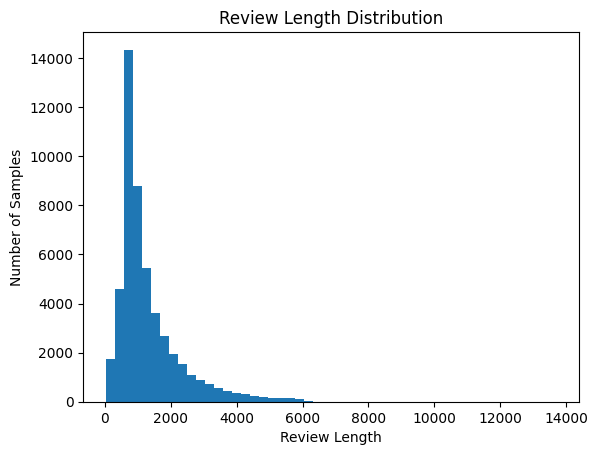

label
0    25000
1    25000
Name: count, dtype: int64


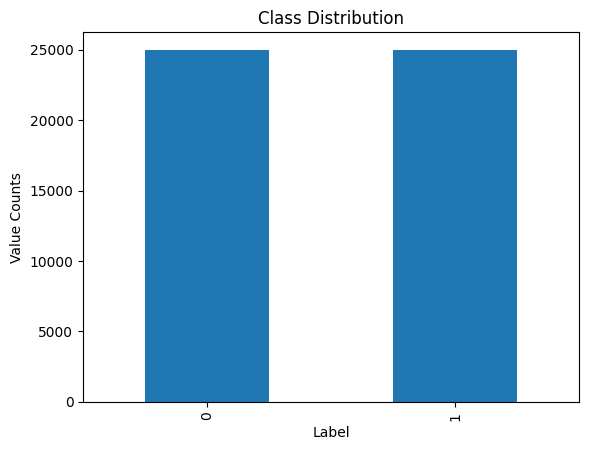

Null values in x train data:  0
Null values in y train data:  0
Null values in x test data:  0
Null values in y test data:  0
Number of duplicated records in training data:  96
Number of duplicated records in test data:  199
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
[[  11 1568   11 ...  291    6   27]
 [  11  236 2120 ...    0    0    0]
 [  44   62    6 ...    0    0    0]
 [  12   20   14 ...    0    0    0]
 [ 430  627  101 ...  318   16 8163]]
[[  11  113  860 ...    0    0    0]
 [ 279    2  729 ...    0    0    0]
 [  93    4  457 ...    0    0    0]
 [ 325  671 2354 ...  269   20  165]
 [  87  123  380 ...    0    0    0]]
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>
Shape of x train after tokenization and pad sequences:  (25000, 256)
Shape of x test after tokenization and pad sequences:  (25000, 256)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 256, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_6           │ (None, 256, 128)       │        99,584 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_6      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,379,713 (5.26 MB)

 Trainable params: 1,379,713 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.6767 - loss: 0.6259 - val_accuracy: 0.7620 - val_loss: 0.5303
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9067 - loss: 0.2399 - val_accuracy: 0.7048 - val_loss: 0.6936
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9396 - loss: 0.1592 - val_accuracy: 0.6930 - val_loss: 0.8920
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9674 - loss: 0.0959 - val_accuracy: 0.7990 - val_loss: 0.5659
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9729 - loss: 0.0801 - val_accuracy: 0.6730 - val_loss: 1.2851
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9823 - loss: 0.0534 - val_accuracy: 0.6930 - val_loss: 1.2298
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9897 - loss: 0.0361 - val_accuracy: 0.6144 - val_loss: 1.7368
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9888 - loss: 0.0357 - va

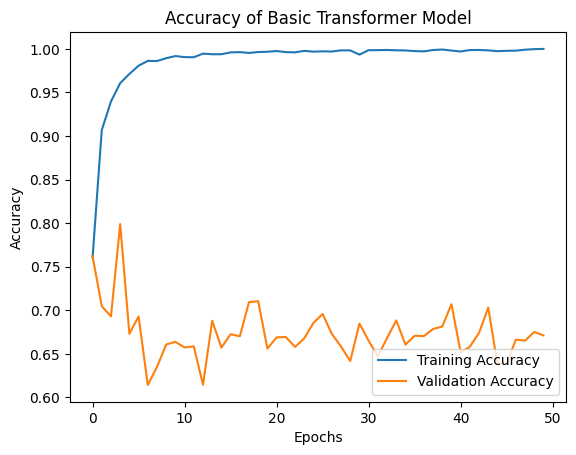

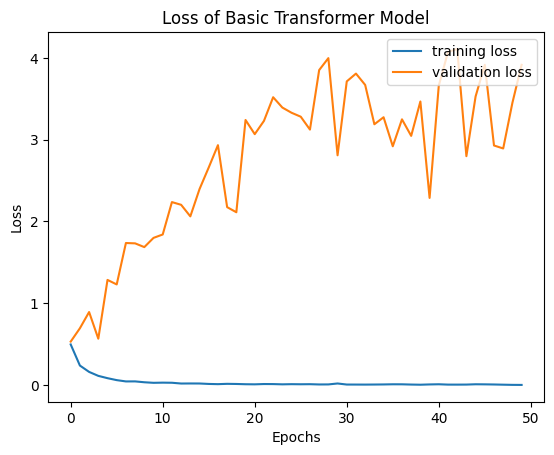

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 256, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_3           │ (None, 256, 128)       │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_7           │ (None, 256, 128)       │        99,584 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_7      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,379,713 (5.26 MB)

 Trainable params: 1,379,713 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.5819 - loss: 0.6851 - val_accuracy: 0.0000e+00 - val_loss: 0.9610
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.6239 - loss: 0.6542 - val_accuracy: 0.1794 - val_loss: 0.9257
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.7643 - loss: 0.4937 - val_accuracy: 0.7568 - val_loss: 0.5156
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8645 - loss: 0.3199 - val_accuracy: 0.6154 - val_loss: 0.7937
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8932 - loss: 0.2649 - val_accuracy: 0.8102 - val_loss: 0.4815
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9065 - loss: 0.2379 - val_accuracy: 0.7884 - val_loss: 0.5439
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9196 - loss: 0.2071 - val_accuracy: 0.8034 - val_loss: 0.4899
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9274 - loss: 0.1922

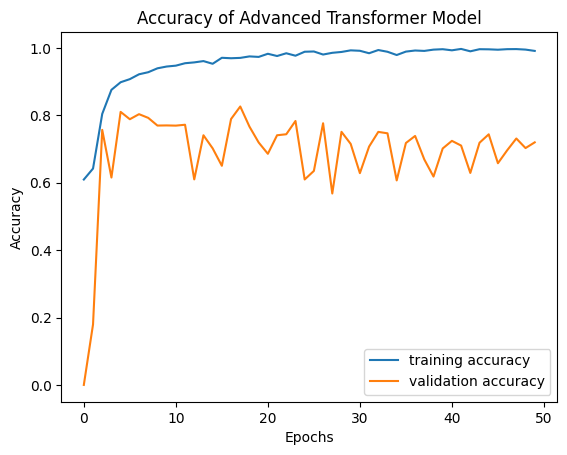

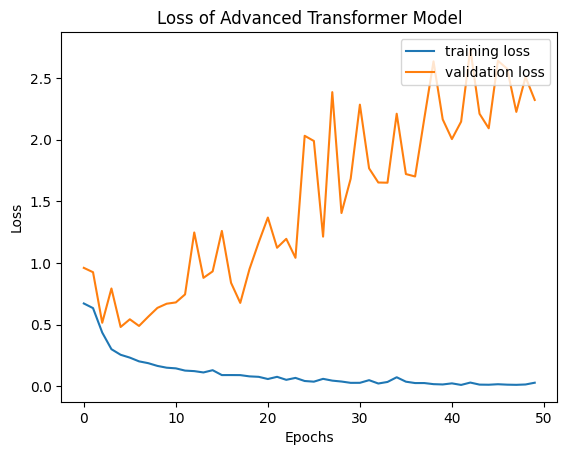

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Accuracy:  0.79628
Precision 0.855183657811451
Recall: 0.71336
F1-Score: 0.7778601648711126
ROC-AUC Score: 0.79628
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Accuracy:  0.82104
Precision 0.8761012183692596
Recall: 0.74784
F1-Score: 0.8069054812257229
ROC-AUC Score: 0.8210400000000001


In [ ]:
def run_workflow():
  df_data, df_train, df_test, x_train, y_train, x_test, y_test = load_and_process_imdb_dataset()
  x_train, y_train, x_test, y_test = eda(df_data, df_train, df_test, x_train, y_train, x_test, y_test)
  basic_model = basic_transformer_model(x_train, y_train)
  advanced_model = advanced_transformer_model(x_train, y_train)
  evaluate(basic_model, x_test, y_test)
  evaluate(advanced_model, x_test, y_test)

run_workflow()